In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import eispac
import pfsspy
import pfsspy.tracing as tracing
from reproject import reproject_interp  

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift
    

In [4]:
def derotate_fsi(fsi_map, hri_map,algorithm="adaptive"):
    out_frame = hri_map.coordinate_frame
    out_center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=out_frame)
    header = sunpy.map.make_fitswcs_header(fsi_map.data.shape,
                                        out_center,
                                        scale=u.Quantity(fsi_map.scale),
                                        rotation_matrix=fsi_map.rotation_matrix)
    out_wcs = WCS(header)

    with propagate_with_solar_surface():
        fsi_map_derot = fsi_map.reproject_to(out_wcs,algorithm=algorithm)

    return fsi_map_derot


In [5]:
def get_loop_length(line):
    c = line.coords.cartesian.xyz
    s = np.append(0., np.linalg.norm(np.diff(c.value, axis=1), axis=0).cumsum()) * c.unit
    return np.diff(s).sum()

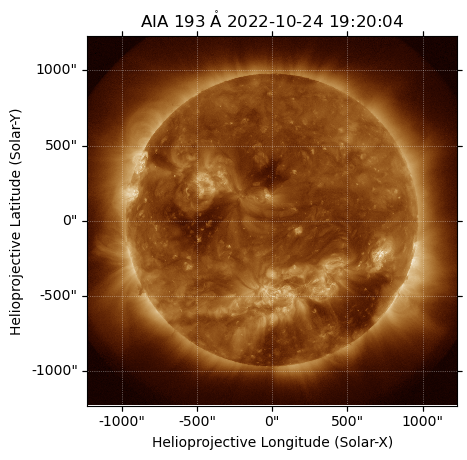

In [6]:
aia_193_map = sunpy.map.Map('../../src/AIA/20221024/193/lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.193.image.fits')
aia_193_map.plot()

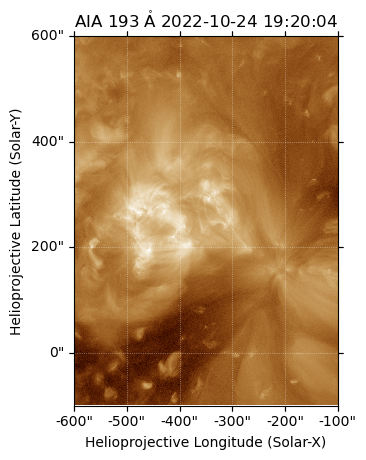

In [7]:
aia_193_map_crop = aia_193_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=aia_193_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=aia_193_map.coordinate_frame))
aia_193_map_crop.plot()

In [8]:
eis_195_velmap_derot = sunpy.map.Map('../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot.fits')

(-0.5, 834.5, -0.5, 1167.5)

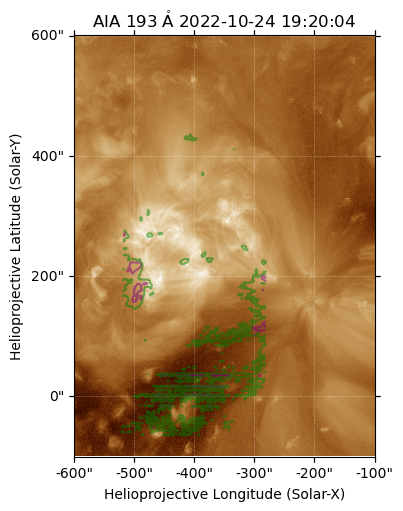

In [10]:
fig = plt.figure(figsize=(15,5),constrained_layout=True)

ax1 = fig.add_subplot(131,projection=aia_193_map_crop)
im1 = aia_193_map_crop.plot(axes=ax1)
bounds = ax1.axis()
eis_195_velmap_derot.draw_contours([-10,-5],colors=["purple","green"], axes=ax1, alpha=0.5)
ax1.axis(bounds)

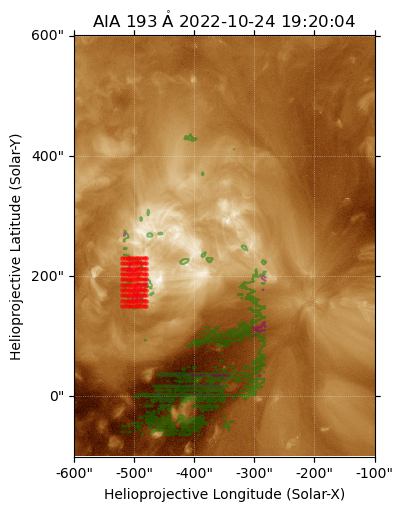

In [13]:
fig = plt.figure(figsize=(15,5),constrained_layout=True)

ax1 = fig.add_subplot(131,projection=aia_193_map_crop)
im1 = aia_193_map_crop.plot(axes=ax1)

bounds = ax1.axis()
eis_195_velmap_derot.draw_contours([-10,-5],colors=["purple","green"], axes=ax1, alpha=0.5)
ax1.axis(bounds)

seed_0_lon, seed_0_lat = np.meshgrid(np.linspace(-520,-480,10), np.linspace(150,230,10))
seed_0 = SkyCoord(seed_0_lon.ravel()*u.arcsec,seed_0_lat.ravel()*u.arcsec,frame=aia_193_map_crop.coordinate_frame)

# seed_0 = SkyCoord(-920*u.arcsec,240*u.arcsec,frame=aia_193_map_crop.coordinate_frame)
ax1.plot_coord(seed_0,marker='.',color='red',markersize=5,alpha=0.5)

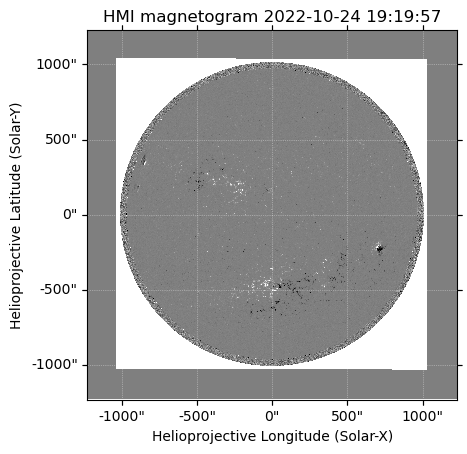

In [14]:
hmi_los_map = sunpy.map.Map("../../src/HMI/20221024/lvl15/hmi.M_45s.20221024_192100_TAI.2.magnetogram.fits")
hmi_los_map.plot_settings['norm'] = plt.Normalize(-500, 500)
hmi_los_map.plot()

In [16]:
hmi_syn_shape_out=[540, 1080]
hmi_syn_frame_out = SkyCoord(0, 0, unit=u.deg, rsun=hmi_los_map.coordinate_frame.rsun, frame="heliographic_stonyhurst", obstime=hmi_los_map.date)
hmi_syn_header = sunpy.map.make_fitswcs_header(
    hmi_syn_shape_out,
    hmi_syn_frame_out,
    scale=[180 / hmi_syn_shape_out[0], 360 / hmi_syn_shape_out[1]] * u.deg / u.pix,
    projection_code="CAR",
)
hmi_syn_out_wcs = astropy.wcs.WCS(hmi_syn_header)

In [19]:
with propagate_with_solar_surface():
    hmi_syn_array, _ = reproject_interp(hmi_los_map, hmi_syn_out_wcs, shape_out=hmi_syn_shape_out)
hmi_syn_array = np.where(np.isnan(hmi_syn_array), 0, hmi_syn_array)

In [21]:
hmi_syn_cea_map = pfsspy.utils.car_to_cea(sunpy.map.Map(hmi_syn_array, hmi_syn_header))
hmi_syn_cea_map.meta['TELESCOP'] = hmi_los_map.meta['TELESCOP']
hmi_syn_cea_map.meta['CONTENT'] = 'Carrington Synoptic Chart Of Br Field'
hmi_syn_cea_map.meta['T_OBS'] = hmi_syn_cea_map.meta.pop('DATE-OBS')

In [26]:
hmi_syn_cea_map = sunpy.map.Map(hmi_syn_cea_map.data, hmi_syn_cea_map.meta,)
hmi_syn_cea_map.plot_settings['cmap'] = 'hmimag'
hmi_syn_cea_map.plot_settings['norm'] = ImageNormalize(vmin=-1500,vmax=1500)

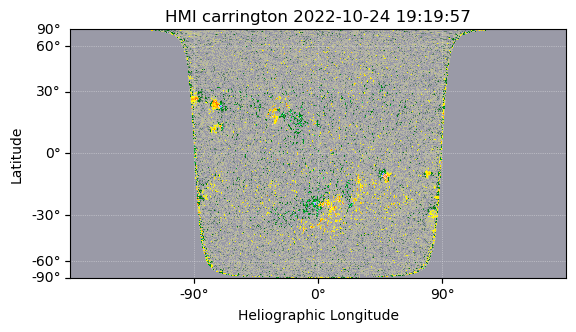

In [27]:
hmi_syn_cea_map.plot()

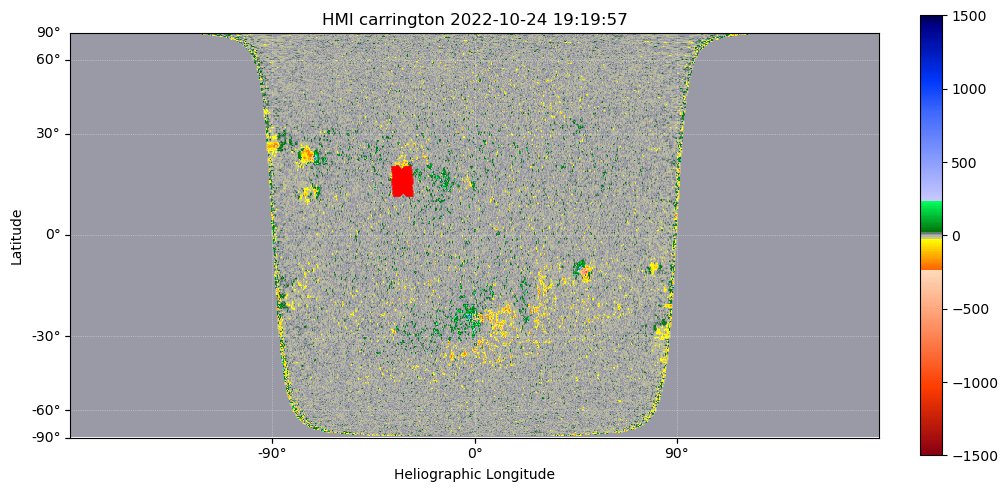

In [29]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=hmi_syn_cea_map)
hmi_syn_cea_map.plot(axes=ax)
plt.colorbar(ax=ax)
ax.plot_coord(seed_0,marker='x',color='red',markersize=10)

In [30]:
nrho = 70
rss = 2.5
pfss_input = pfsspy.Input(hmi_syn_cea_map, nrho, rss)
pfss_output = pfsspy.pfss(pfss_input)

In [31]:
tracer_0 = tracing.FortranTracer()
with propagate_with_solar_surface():
    flines_0 = tracer_0.trace(seed_0, pfss_output)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


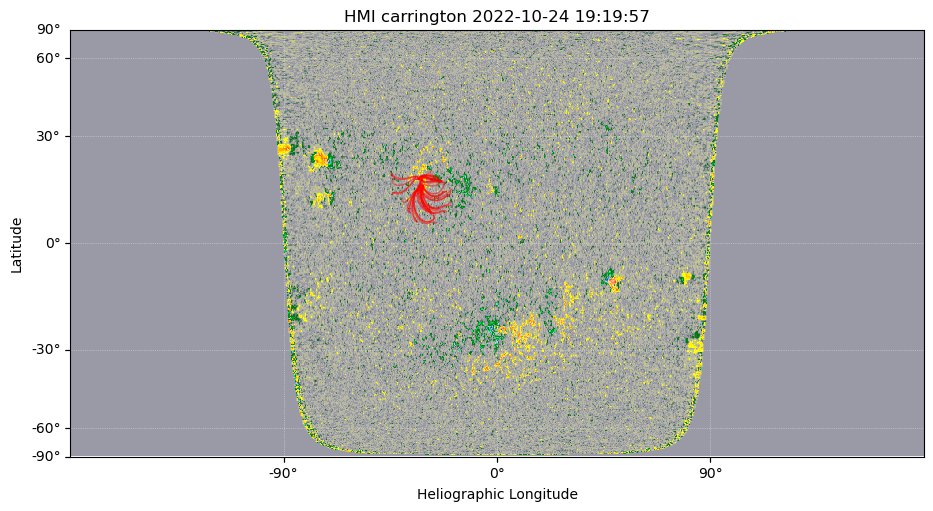

In [39]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=hmi_syn_cea_map)
hmi_syn_cea_map.plot(axes=ax)

with propagate_with_solar_surface():
    for fline in flines_0:
        if get_loop_length(fline) > 100 * u.Mm:
            ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)

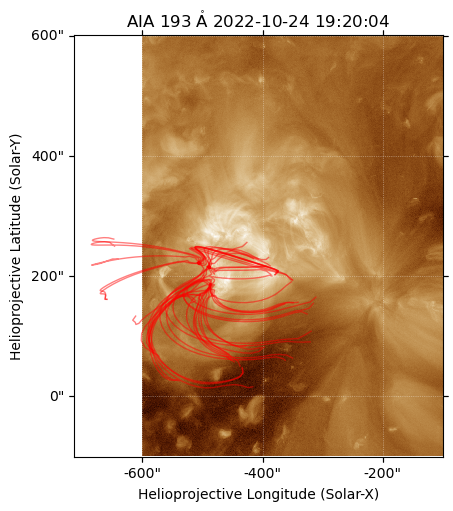

In [35]:
fig = plt.figure(figsize=(5,5),constrained_layout=True)

ax = fig.add_subplot(111,projection=aia_193_map_crop)
aia_193_map_crop.plot(axes=ax)

with propagate_with_solar_surface():
    for fline in flines_0:
        if get_loop_length(fline) > 100 * u.Mm:
            ax.plot_coord(fline.coords, color='red', linewidth=1,alpha=0.5)